In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sbi import utils as sbi_utils
from sbi import inference as sbi_inference
from sbi.inference import simulate_for_sbi
from sbi.analysis import plot_summary
import pymc as pm
import arviz as az

In [2]:
def setup_environment():
    
    device = torch.device("cpu")
    torch.manual_seed(0)
    x_grid = torch.linspace(-1.0, 1.0, 20).to(device)
    sigma_noise = 0.1
    theta_true = torch.tensor([1.0, 0.3]).to(device)
    prior_low = torch.tensor([-5.0, -5.0]).to(device)
    prior_high = torch.tensor([5.0, 5.0]).to(device)
    prior = sbi_utils.BoxUniform(low=prior_low, high=prior_high)
    
    return device, x_grid, sigma_noise, theta_true, prior, prior_low, prior_high

In [3]:
def simulator(theta, x_grid, sigma_noise):
    
    m = theta[..., 0]
    c = theta[..., 1]
    noise = torch.randn_like(x_grid) * sigma_noise
    
    return m[..., None] * x_grid + c[..., None] + noise

In [4]:
def analytic_posterior(x_grid, y_obs, sigma_noise, prior_low, prior_high):
    
    var_uniform = ((prior_high - prior_low) ** 2) / 12.0
    Sigma0 = torch.diag(var_uniform)
    Sigma0_inv = torch.inverse(Sigma0)
    X_mat = torch.stack([x_grid, torch.ones_like(x_grid)], dim=1)
    Sigma_post_inv = Sigma0_inv + (1.0 / sigma_noise**2) * X_mat.T @ X_mat
    Sigma_post = torch.inverse(Sigma_post_inv)
    mu_post = Sigma_post @ (
        Sigma0_inv @ torch.zeros(2) + (1.0 / sigma_noise**2) * X_mat.T @ y_obs
    )
    
    return mu_post, Sigma_post

In [5]:
def mcmc(x_grid, y_obs, sigma_noise):
    
    x_np = x_grid.cpu().numpy()
    y_np = y_obs.cpu().numpy()
    with pm.Model() as model:
        m = pm.Uniform("m", lower=-5, upper=5)
        c = pm.Uniform("c", lower=-5, upper=5)
        y_est = m * x_np + c
        y_like = pm.Normal("y_like", mu=y_est, sigma=sigma_noise, observed=y_np)
        trace = pm.sample(2000, tune=1000, chains = 4, cores=2, return_inferencedata=True, progressbar=True)
    mcmc_samples = trace.posterior.stack(samples=("chain", "draw"))
    mcmc_m = mcmc_samples["m"].values.flatten()
    mcmc_c = mcmc_samples["c"].values.flatten()
    
    return torch.tensor(np.vstack([mcmc_m, mcmc_c]).T)

In [6]:
def sbi(sim_wrapper, prior, y_obs, num_simulations=2000):
    
    print(f"SBI: {num_simulations} simulations")
    thetas, xs = simulate_for_sbi(sim_wrapper, prior, num_simulations=num_simulations)
    inference = sbi_inference.SNPE(prior=prior)
    print("SBI: Training")
    density_estimator = inference.append_simulations(thetas, xs).train()
    posterior = inference.build_posterior(density_estimator)
    print("SBI: Sampling")
    samples = posterior.sample((10000,), x=y_obs)
    plot_summary(inference, tags=["training_loss", "validation_loss"])
    
    return samples, inference

SBI: 2000 simulations


  0%|          | 0/2000 [00:00<?, ?it/s]

SBI: Training
SBI: Samplingrk successfully converged after 340 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=C:\Users\svenv\Desktop\Boeken en sylabussen\Master\Machine Learning\Project\Code\SBI_Project2b\Linear Regression\sbi-logs\NPE_C\2025-05-11T19_01_34.827923' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 56 seconds.


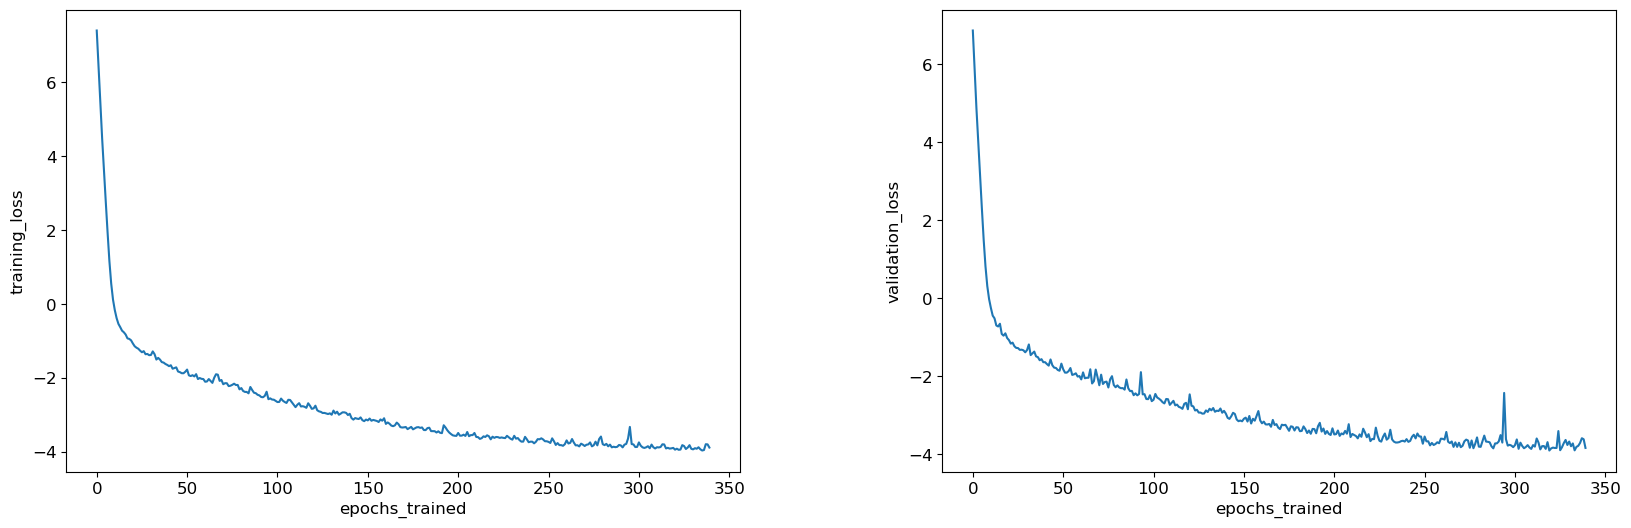

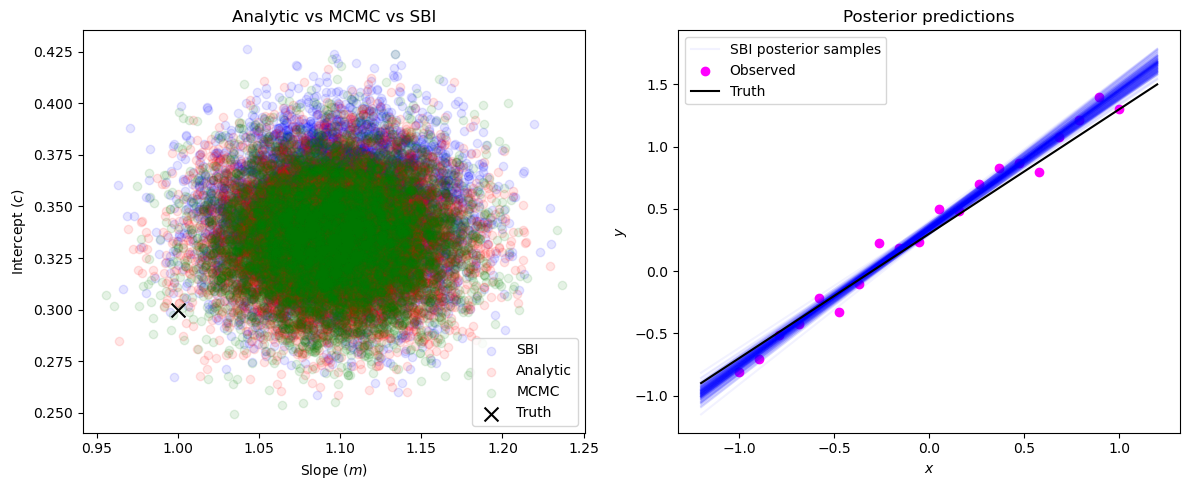

In [7]:
device, x_grid, sigma_noise, theta_true, prior, prior_low, prior_high = setup_environment()

sim_wrapper = lambda theta: simulator(theta, x_grid=x_grid, sigma_noise=sigma_noise)
with torch.no_grad():
    y_obs = sim_wrapper(theta_true)

posterior_samples, inference = sbi(sim_wrapper, prior, y_obs)
mu_post, sigma_post = analytic_posterior(x_grid, y_obs, sigma_noise, prior_low, prior_high)
analytic_samples = torch.distributions.MultivariateNormal(mu_post, sigma_post).sample((10000,))
mcmc_samples = mcmc(x_grid, y_obs, sigma_noise)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(posterior_samples[:, 0], posterior_samples[:, 1], alpha=0.1, label="SBI", color="blue")
ax[0].scatter(analytic_samples[:, 0], analytic_samples[:, 1], alpha=0.1, label="Analytic", color="red")
ax[0].scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], alpha=0.1, label="MCMC", color="green")
ax[0].scatter([theta_true[0]], [theta_true[1]], marker="x", s=100, label="Truth", color="black")
ax[0].set_xlabel(r"Slope ($m$)")
ax[0].set_ylabel(r"Intercept ($c$)")
ax[0].set_title("Analytic vs MCMC vs SBI")
ax[0].legend()

x_dense = torch.linspace(-1.2, 1.2, 100)
m0, c0 = posterior_samples[0]
ax[1].plot(x_dense, m0 * x_dense + c0, alpha=0.05, label="SBI posterior samples", color="blue")
for i in range(1, 200):
    m_i, c_i = posterior_samples[i]
    ax[1].plot(x_dense, m_i * x_dense + c_i, alpha=0.05, color="blue")
ax[1].scatter(x_grid, y_obs, label="Observed", color="magenta")
ax[1].plot(x_dense, theta_true[0] * x_dense + theta_true[1], label="Truth", color="black")
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$y$")
ax[1].set_title("Posterior predictions")
ax[1].legend()

plt.tight_layout()
plt.show()